### This notebook imports alternate versions of the same reference grid--rotated according to different plate models--and presents some statistical analyses of them. 

In [6]:
import numpy as np
import pandas as pd
import pygplates as pygp
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as crs

#### User input

In [7]:
start = 10
stop = 540
step = 10

models = ['WR13', 'TC16', 'SC16', 'ME21', 'MA16']
files = ['rotated_grids/WR13.csv', 'rotated_grids/TC16.csv', 'rotated_grids/SC16.csv', 'rotated_grids/ME21.csv', 'rotated_grids/MA16.csv']
reference_grid = 'reference_grid/reference_grid.csv'

#### Import the alternate rotated grids and assign each to a dataframe

In [9]:
ref_pts = pd.read_csv(reference_grid, usecols=[0,1], header=0).dropna().reset_index(drop=True)

df = {}
for i, mod in enumerate(models):
    cols = []
    data = pd.read_csv(files[i], header=0)
    if not (ref_pts['lat'].equals(data['lat']) or ref_pts['lng'].equals(data['lng'])): # check that the points at present-day are the same as reference grid
        print ('WARNING! Point lists at t=0 are not the same as reference grid values!')
    
    for time in range(start, stop+step, step):
        cols.append(time)
        if f'lat_{time}' in data.columns:
            data[time] = data[[f'lat_{time}', f'lng_{time}']].apply(tuple, axis=1)
        else:
            data[time] = [(999, 999)] * len(data)
    df[mod] = data[cols]

#### Collapse the dataframes together

In [15]:
merged = pd.concat(df, axis=1, keys=models)    # collapse into single dataframe
merged = merged.stack(0)                    # and make MultiIndexed so that we can search through model dimension if needed
merged = merged.groupby(level=0).agg(list)

#### Extract the latitudes and compute their standard deviations

In [5]:
def lat_std(points):   # function to extract the latitudes from each element-wise lise of reconstructed points
    if pd.isnull(points).any(): return np.nan
    lats = []
    for point in points: 
        if point[0] != 999: lats.append(point[0])
    return np.std(lats)

In [6]:
df_latstd = merged.applymap(lat_std)        # compute the standard deviation of each latitude array

#### Bin the standard deviations into a set of simplified ranges

In [7]:
std_ranges = [0, 2, 5, 9, 15, np.nanmax(df_latstd.values)] 
dfg_latstd = pd.concat([df_latstd[col].groupby(pd.cut(df_latstd[col], bins=std_ranges)).count() for col in df_latstd.columns], axis=1) # count data by ranges
dfg_latstd_norm = dfg_latstd.apply(lambda x: x/x.sum(), axis=0)   # normalize the counts of each column so they sum to 1

#### Re-arrange the dataframe and plot the results

In [8]:
dfg_latstd_norm = dfg_latstd_norm[::-1]   # flip the dataframe axis (for plotting)
dfg_latstd_norm = dfg_latstd_norm.T       # invert rows and columns (for plotting)
dfg_latstd_norm = dfg_latstd_norm[::-1]   # now flip the other axis (for plotting)

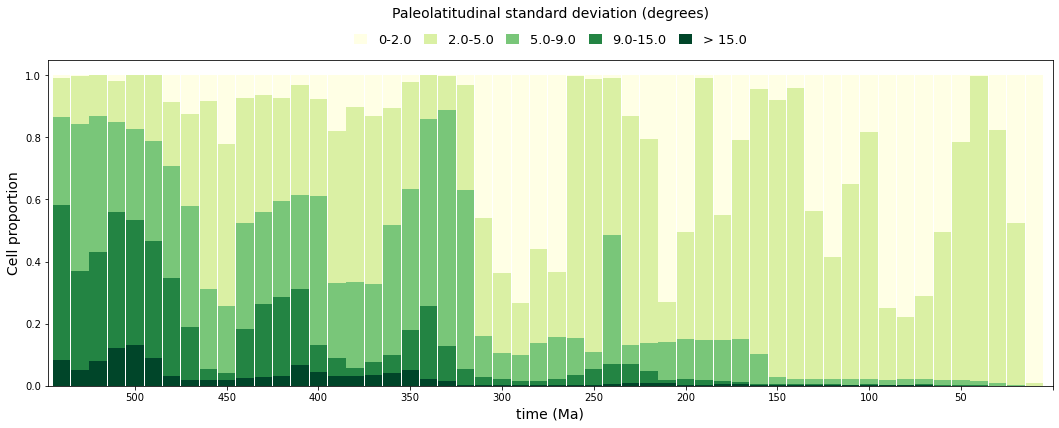

In [9]:
ax = dfg_latstd_norm.plot(kind='bar', stacked='True', width=0.95, colormap='YlGn_r', figsize=(18,6))
ax.set_title('Paleolatitudinal standard deviation (degrees)', fontsize=14, y=1.11)
ax.set_xlabel('time (Ma)', fontsize=14)
ax.set_ylabel('Cell proportion', fontsize=14)
ax.set_xticks(np.arange(4, 56, 5))
ax.tick_params(labelrotation=0)

leg1 = '> %.1f' % std_ranges[4]
leg2 = '%.1f-%.1f' % (std_ranges[3], std_ranges[4])
leg3 = '%.1f-%.1f' % (std_ranges[2], std_ranges[3]) 
leg4 = '%.1f-%.1f' % (std_ranges[1], std_ranges[2]) 
leg5 = '0-%.1f' % std_ranges[1] 
leg_labels = [leg1, leg2, leg3, leg4, leg5]
leg_order = [4, 3, 2, 1, 0]
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[i] for i in leg_order], [leg_labels[i] for i in leg_order], ncol=5,
           handlelength = 1, columnspacing=1, fontsize=13, bbox_to_anchor=(0.5, 1.06), loc='center', frameon=False)

plt.savefig('latstd.pdf')

#### Visualize the standard deviations in space through time

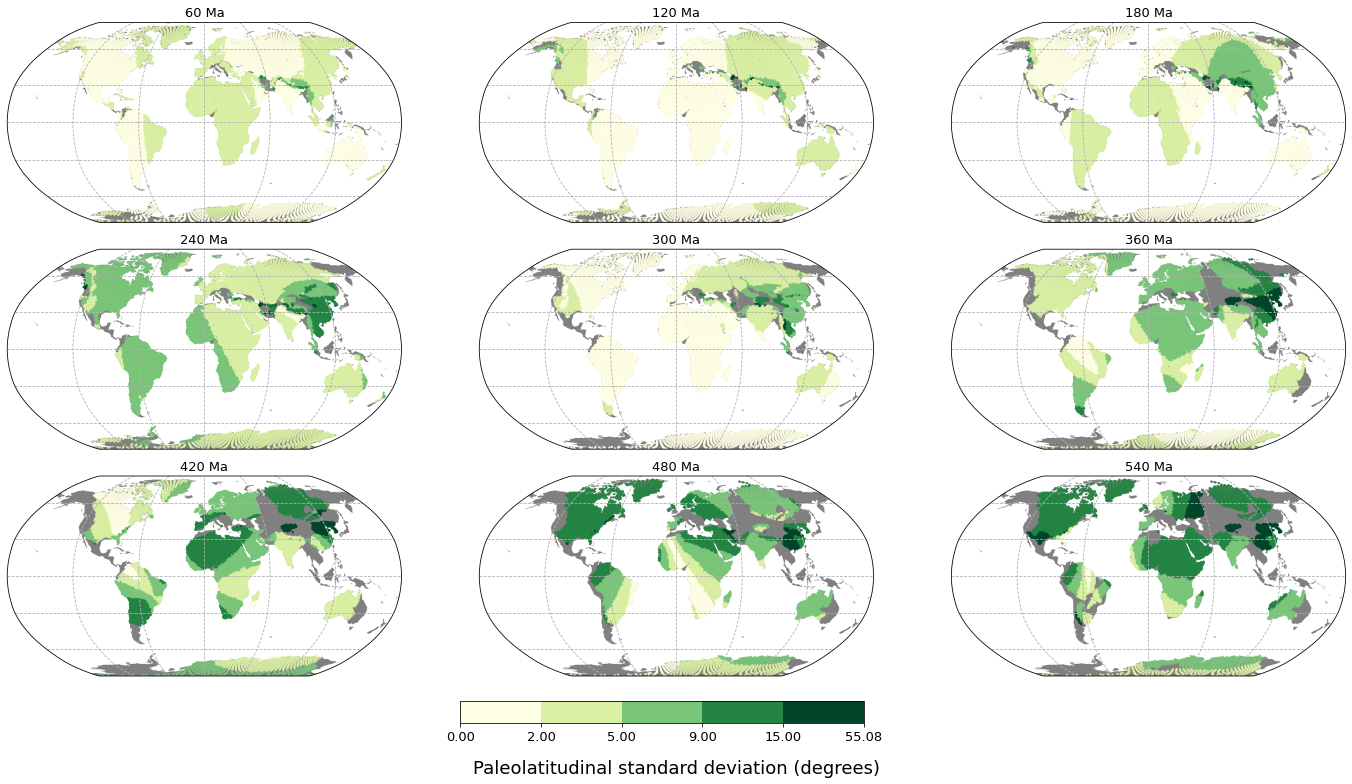

In [10]:
times = [60, 120, 180, 240, 300, 360, 420, 480, 540]
cmap = plt.cm.YlGn
norm = mpl.colors.BoundaryNorm(std_ranges, cmap.N)  # discretize colorbar by standard deviation ranges selected above

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,10), subplot_kw={'projection': crs.Robinson()})  # plot selected time steps
fig.suptitle('Paleolatitudinal standard deviation (degrees)', fontsize=18, y=-0.1)

counter = 0
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(ref_pts['lng'], ref_pts['lat'], s=2, alpha=0.8, transform=crs.PlateCarree(), 
                        c=df_latstd[times[counter]], cmap=cmap, norm=norm)
        ax[i,j].set_global()  
        ax[i,j].add_feature(cartopy.feature.LAND, facecolor='gray')
        ax[i,j].gridlines(linestyle='--')
        ax[i,j].set_title('%i Ma' % times[counter], fontsize=13)
        counter+=1
plt.tight_layout()

c_map_ax = fig.add_axes([0.35, -0.05, 0.28, 0.03])
mpl.colorbar.ColorbarBase(c_map_ax, cmap=cmap, norm=norm, orientation = 'horizontal')
c_map_ax.tick_params(labelsize=13)

plt.savefig('latstd_map.pdf')

#### Compute the mean distance between alternate versions of each reconstructed point

In [11]:
def mean_dist(points):
    if pd.isnull(points).any(): return np.nan
    dists = []
    for i, pti in enumerate(points):
        for j, ptj in enumerate(points):
            if (i < j and (pti[0] != 999 and ptj[0] != 999)):
                arc = pygp.GreatCircleArc(pti, ptj)
                dists.append(arc.get_arc_length() * pygp.Earth.mean_radius_in_kms)
    mdist = np.array(dists).sum()/np.sum(range(len(points)))
    return mdist

In [12]:
df_mdists = merged.applymap(mean_dist)

#### Bin the average distances into a set of simplified ranges

In [13]:
mdist_ranges = [0, 750, 1500, 3000, 5000, np.nanmax(df_mdists.values)]
dfg_mdists = pd.concat([df_mdists[col].groupby(pd.cut(df_mdists[col], bins=mdist_ranges)).count() for col in df_mdists.columns], axis=1)
dfg_mdists_norm = dfg_mdists.apply(lambda x: x/x.sum(), axis=0)

#### Re-arrange the dataframe and plot the results

In [14]:
dfg_mdists_norm = dfg_mdists_norm[::-1]
dfg_mdists_norm = dfg_mdists_norm.T
dfg_mdists_norm = dfg_mdists_norm[::-1]

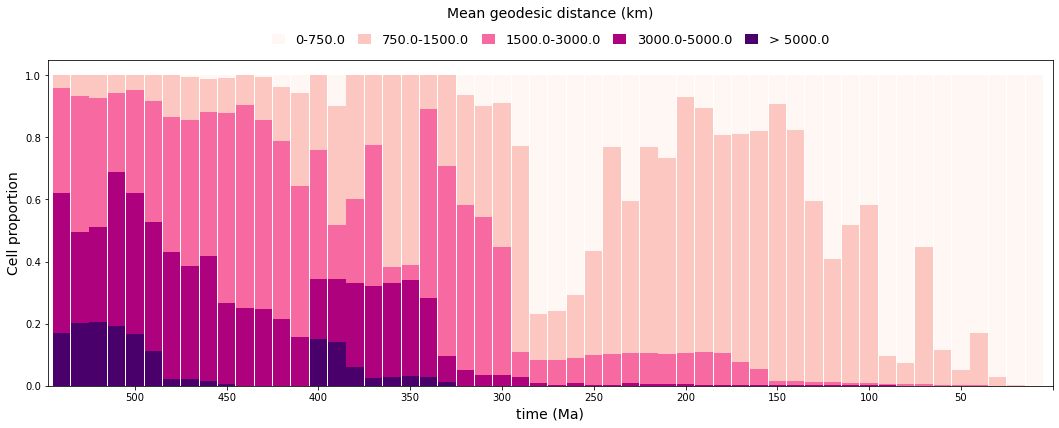

In [15]:
ax = dfg_mdists_norm.plot(kind='bar', stacked='True', width=0.95, colormap='RdPu_r', figsize=(18,6))
ax.set_title('Mean geodesic distance (km)', fontsize=14, y=1.11)
ax.set_xlabel('time (Ma)', fontsize=14)
ax.set_ylabel('Cell proportion', fontsize=14)
ax.set_xticks(np.arange(4, 56, 5))
ax.tick_params(labelrotation=0)

leg1 = '> %.1f' % mdist_ranges[4]
leg2 = '%.1f-%.1f' % (mdist_ranges[3], mdist_ranges[4])
leg3 = '%.1f-%.1f' % (mdist_ranges[2], mdist_ranges[3]) 
leg4 = '%.1f-%.1f' % (mdist_ranges[1], mdist_ranges[2]) 
leg5 = '0-%.1f' % mdist_ranges[1] 
leg_labels = [leg1, leg2, leg3, leg4, leg5]
leg_order = [4, 3, 2, 1, 0]
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[i] for i in leg_order], [leg_labels[i] for i in leg_order], ncol=5,
           handlelength = 1, columnspacing=1, fontsize=13, bbox_to_anchor=(0.5, 1.06), loc='center', frameon=False)

plt.savefig('mdists.pdf')

#### Visualize the standard deviations in space through time

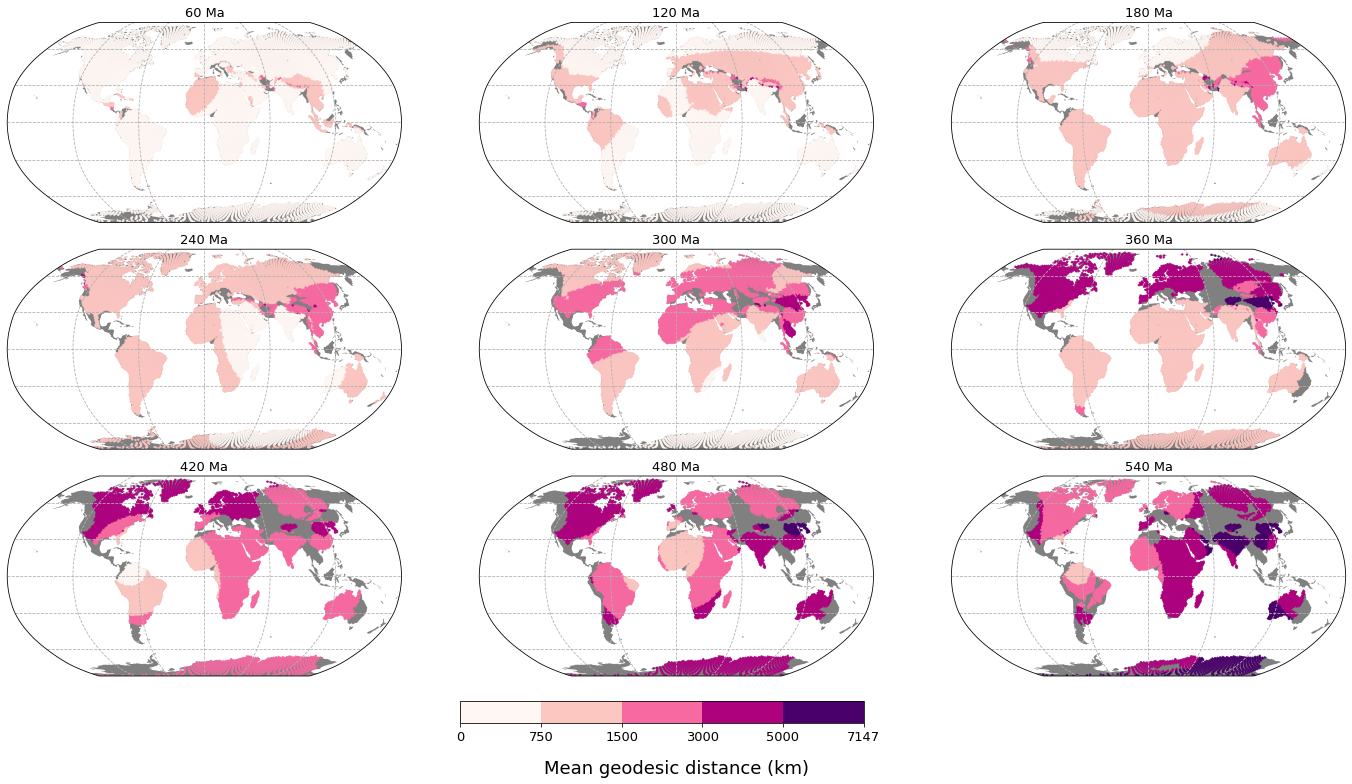

In [16]:
times = [60, 120, 180, 240, 300, 360, 420, 480, 540]    # set times for which to plot maps
cmap = plt.cm.RdPu
norm = mpl.colors.BoundaryNorm(mdist_ranges, cmap.N)  # discretize colorbar by standard deviation ranges selected above

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,10), subplot_kw={'projection': crs.Robinson()})  # plot selected time steps
fig.suptitle('Mean geodesic distance (km)', fontsize=18, x=0.5, y=-0.1)

counter = 0
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(ref_pts['lng'], ref_pts['lat'], s=2, alpha=0.8, transform=crs.PlateCarree(), 
                        c=df_mdists[times[counter]], cmap=cmap, norm=norm)
        ax[i,j].set_global()  
        ax[i,j].add_feature(cartopy.feature.LAND, facecolor='gray')
        ax[i,j].gridlines(linestyle='--')
        ax[i,j].set_title('%i Ma' % times[counter], fontsize=13)
        counter+=1
plt.tight_layout()

c_map_ax = fig.add_axes([0.35, -0.05, 0.28, 0.03])
mpl.colorbar.ColorbarBase(c_map_ax, cmap=cmap, norm=norm, orientation = 'horizontal')
c_map_ax.tick_params(labelsize=13)

plt.savefig('mdists_map.pdf')